# __Bokking reviews__

__КАКОЙ КЕЙС РЕШАЕМ?__
* __Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.__

#### __Первоначальная версия датасета содержит 17 полей со следующей информацией:__

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

#### __Задача:__
* __Построить модель, которая будет предсказывать рейтинг отеля.__

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### 1. Изучение представленных данных.

In [18]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [19]:
# дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>,
        <AxesSubplot:title={'center':'sample'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

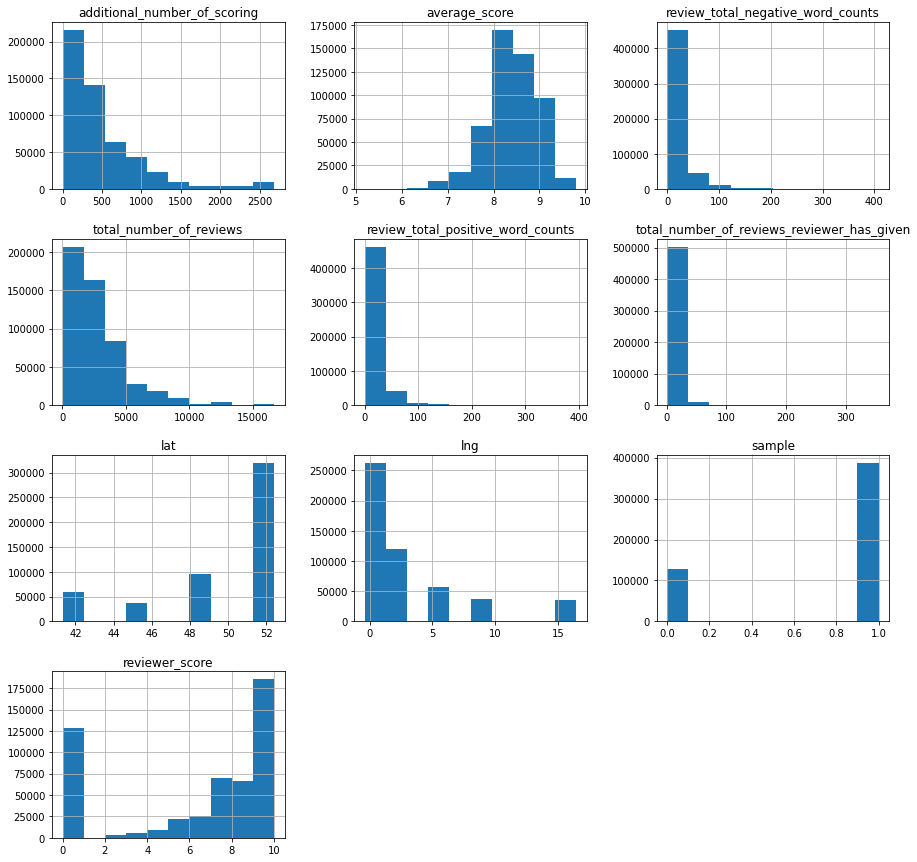

In [6]:
# Посмотрим на распределение числовых признаков.
data.hist(figsize = (15,15))

Итак, имеем данные с отзывами на отели Европы 515738 отзывов всего.
Пропуски есть в признаках:
- lat — географическая широта отеля (3268 пропусков);
- lng — географическая долгота отеля (3268 пропусков).

Сразу обозначим, что скорее всего эти признаки не влияют на оценку ревьюера. Если пользователь бронирует отель, например, в Париже, вряд ли выставленная оценка будет как-то зависима от координат отеля. Можно посмотреть расстояние до центра города, имея координаты отеля, но бронируя отель не в центре (эта информация на букинге указывается), вряд ли ревьюер будет на это опираться при проставлении оценки, якобы ожидая, что он в другом месте не в том, в котором указано на сайте букинга. Скорее всего на оценку пользователя влияют соотношения ожидания и реальности. Какую-либо информацию про ожидания и полученный результат в большей степени влияющие на рейтинг отеля мы сможем получить из признаков про сами отзывы (сам текст). Опять таки бронируя отель в Париже, вряд ли пользователь ожидает другой город, другую страну, кроме Франции. 

План действий:
- выделяем полезные признаки,
- анализируем корреляцию между признаками,
- строим модель, делаем выводы.

### 2. Подготавливаем данные.

In [21]:
# Добавим признаким по месяцу когда был оставлен отзыв 
data['review_month'] = pd.to_datetime(data['review_date']).dt.month
data['review_week_day'] = pd.to_datetime(data['review_date']).dt.day_of_week
warm = [3, 4, 5, 6, 7, 8, 9] # сентябрь отнесем к теплому времени года, все-таки Европа
data['season_of_review'] = data['review_month'].map(lambda x: 1 if x in warm else 0)

In [22]:
# Посмотрим на соотношение "летних" (1) и "зимних" (0) отзывов.
data['season_of_review'].value_counts()

1    315797
0    199941
Name: season_of_review, dtype: int64

In [23]:
# Посмотрим на содержание информации в тэгах
tags = set() # для определения количества уникальных тэгов
tags_list = list() # для опредления списка всех тэгов
for index, value in data['tags'].items():
        pre_tags = value
        pre_tags = pre_tags.replace('[', '').replace(']', '') # чистим данные
        pre_tags = pre_tags.replace("'", '') # убираем лишние кавычки
        pre_tags = pre_tags.split(",")
        for i in pre_tags:
            tags.add(i.strip())
            tags_list.append(i.strip())
print(len(tags), '- количество уникальных тэгов')
print(len(tags_list), '- количество тэгов')

2428 - количество уникальных тэгов
2356592 - количество тэгов


In [24]:
# Посмотрим на самые популярные тэги и создадим для удобства объект сериес:
tags_s = pd.Series(
    data = tags_list,
    index = tags_list,
    name = 'tags_series'
)
print(tags_s.value_counts()[:50])

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Deluxe Double Room                 24823
Double or Twin Room                22393
Stayed 5 nights                    20845
Standard Double or Twin Room       17483
Classic Double Room                16989
Superior Double or Twin Room       13570
2 rooms                            12393
Stayed 6 nights                     9776
Standard Twin Room                  9745
Single Room     

Всего 515738 отзывов, при том что самый популярный тэг 'Leisure trip' (Поездка на отдых), что составляет порядка 81%.

In [25]:
# выделим количество ночей, проведенных клиентом в отеле
# создадим функцию, отыскивающую нужный тег и возвращающую количество дней:
def days_count(arg):
    tag_list = arg.split(',')
    for tag in tag_list:
        item = tag.find('night')
        if item > 0:
            num_list = tag.split()
            for num in num_list:
                if num.isnumeric():
                    return int(num)
# создадим признак по времени пребывания в отеле            
data['length_of_stay(days)'] = data['tags'].apply(days_count)
data['length_of_stay(days)'].value_counts()

1.0     193644
2.0     133936
3.0      95825
4.0      47817
5.0      20843
6.0       9776
7.0       7399
8.0       2502
9.0       1293
10.0       889
11.0       418
12.0       316
14.0       247
13.0       246
15.0       117
16.0        57
17.0        42
18.0        33
19.0        29
21.0        23
20.0        19
27.0        11
30.0        11
23.0        10
22.0        10
25.0         7
26.0         7
28.0         7
24.0         6
29.0         5
31.0         1
Name: length_of_stay(days), dtype: int64

In [26]:
# Посмотрим на содержание признака по негативным отзывам.
data['negative_review'].value_counts()[:50]

No Negative                    127890
 Nothing                        14295
 Nothing                         4236
 nothing                         2225
 N A                             1037
 None                             984
                                  849
 N a                              509
 Breakfast                        407
 Small room                       373
 Location                         368
 Everything                       326
 All good                         318
 Nothing really                   316
 none                             302
 nothing                          283
 No complaints                    274
 Price                            260
 Nothing really                   254
 Nil                              247
 n a                              227
 Nothing at all                   221
 Nothing to dislike               209
 Nothing at all                   194
 Small rooms                      188
 None                             182
 No complain

В признаке 'negative_review' имеются отзывы, которые не относятся к негативной оценке: "'Nothing', 'Nothing really', 
    'Everything was perfect', 
    'Nothing to dislike', 
    'Everything was great', 
    'NOTHING'.
    
 Выделим признак, означающий отсутствие негатива в негативном отзыве.

In [27]:
noneg_list = [
    'Nothing', 'Nothing really', 
    'Everything was perfect', 
    'Nothing to dislike', 
    'Everything was great', 
    'NOTHING']
data['no_negative_in_neg_rev'] = data['negative_review'].map(lambda x: 1 if x in noneg_list else 0)

Применим вышеобозначенные манипуляции и к 'positive_review'.

In [28]:
data['positive_review'].value_counts()[:50]

No Positive                    35946
 Location                       9222
 Everything                     2284
 location                       1677
 Nothing                        1243
 The location                   1126
 Great location                 1047
 Good location                   927
 Location                        915
 Everything                      613
 Breakfast                       608
 Friendly staff                  515
 Staff                           453
 Excellent location              392
 Great location                  372
 Location and staff              333
 everything                      319
 Good location                   276
 Nothing                         225
 Comfy bed                       222
 nothing                         217
 The location                    215
 good location                   206
 The staff                       197
 Good breakfast                  189
                                 183
 Location staff                  180
 

In [29]:
nopos_list = [
    'No Positive', 
    'Nothing', 
    'nothing', 
    ]
data['no_positive_in_pos_rev'] = data['positive_review'].map(lambda x: 1 if x in nopos_list else 0)

In [31]:
# Из отзывов выделим эмоциональную окраску текста в отзывах
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()


# в результате обработки выдается словарь с четырьмя парами ключ:значение
# по негативным отзывам
data['negative_review'] = data['negative_review'].apply(sent_analyzer.polarity_scores)
# по позитивным отзывам
data['positive_review'] = data['positive_review'].apply(sent_analyzer.polarity_scores)

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [32]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lat,lng,sample,reviewer_score,review_month,review_week_day,season_of_review,length_of_stay(days),no_negative_in_neg_rev,no_positive_in_pos_rev
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...",52,16670,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",...,45.533137,9.171102,0,0.0,7,4,1,2.0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...",10,5018,"{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",...,52.385649,4.834443,0,0.0,12,0,0,1.0,0,1


In [33]:
# создадим новые признаки из негативнного отзыва
data['neg_neg'] = data['negative_review'].apply(lambda x: x['neg'])
data['neg_neu'] = data['negative_review'].apply(lambda x: x['neu'])
data['neg_pos'] = data['negative_review'].apply(lambda x: x['pos'])
data['neg_compound'] = data['negative_review'].apply(lambda x: x['compound'])

# создадим новые признаки из позитивного отзыва
data['pos_neg'] = data['positive_review'].apply(lambda x: x['neg'])
data['pos_neu'] = data['positive_review'].apply(lambda x: x['neu'])
data['pos_pos'] = data['positive_review'].apply(lambda x: x['pos'])
data['pos_compound'] = data['positive_review'].apply(lambda x: x['compound'])

In [34]:
# удалим ненужные теперь признаки отзывов
data.drop(['negative_review', 'positive_review'], axis=1, inplace=True)

In [80]:
# Имеем пустые значения в признаках координат отеля, заполним их нулями
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)
# пустые значения пребывания заменим на самые распрастраненные
data['length_of_stay(days)'] = data['length_of_stay(days)'].fillna(data['length_of_stay(days)'].median())

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [41]:
# выделим признак город из адреса отеля (в адресе город указывается предпеследним, если страна UK, то 5 с конца)
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-2] != 'United' 
                                                              else x.split()[-5]) 
# One-Hot-Coding
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True) # указываем столбец для кодирования 
type_bin = encoder.fit_transform(data['city']) 
data = pd.concat([data, type_bin], axis=1)


In [45]:
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

In [47]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,pos_neu,pos_pos,pos_compound,city,city_Milan,city_Amsterdam,city_Barcelona,city_London,city_Paris,city_Vienna
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,...,0.671,0.329,0.9615,Milan,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,10,5018,0,7,...,0.000,0.621,0.3400,Amsterdam,0,1,0,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,3,351,5,15,...,0.260,0.740,0.6908,Barcelona,0,0,1,0,0,0


Так как отелей у нас 1492, признак номинальный - используем бинарное кодирование)

In [48]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования 
type_bin = bin_encoder.fit_transform(data['hotel_name']) 
data = pd.concat([data, type_bin], axis=1)


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 48 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [50]:
# делаем копию
booking = data.copy()

__Итак, было 18 признаков. Изначально, определив самые полезные в виде тэгов и самого текста отзыва, было создано еще 40. Обилие признаков обусловлено кодированием, для удобства и возможности отработки модели__

## Анализ данных

<AxesSubplot:>

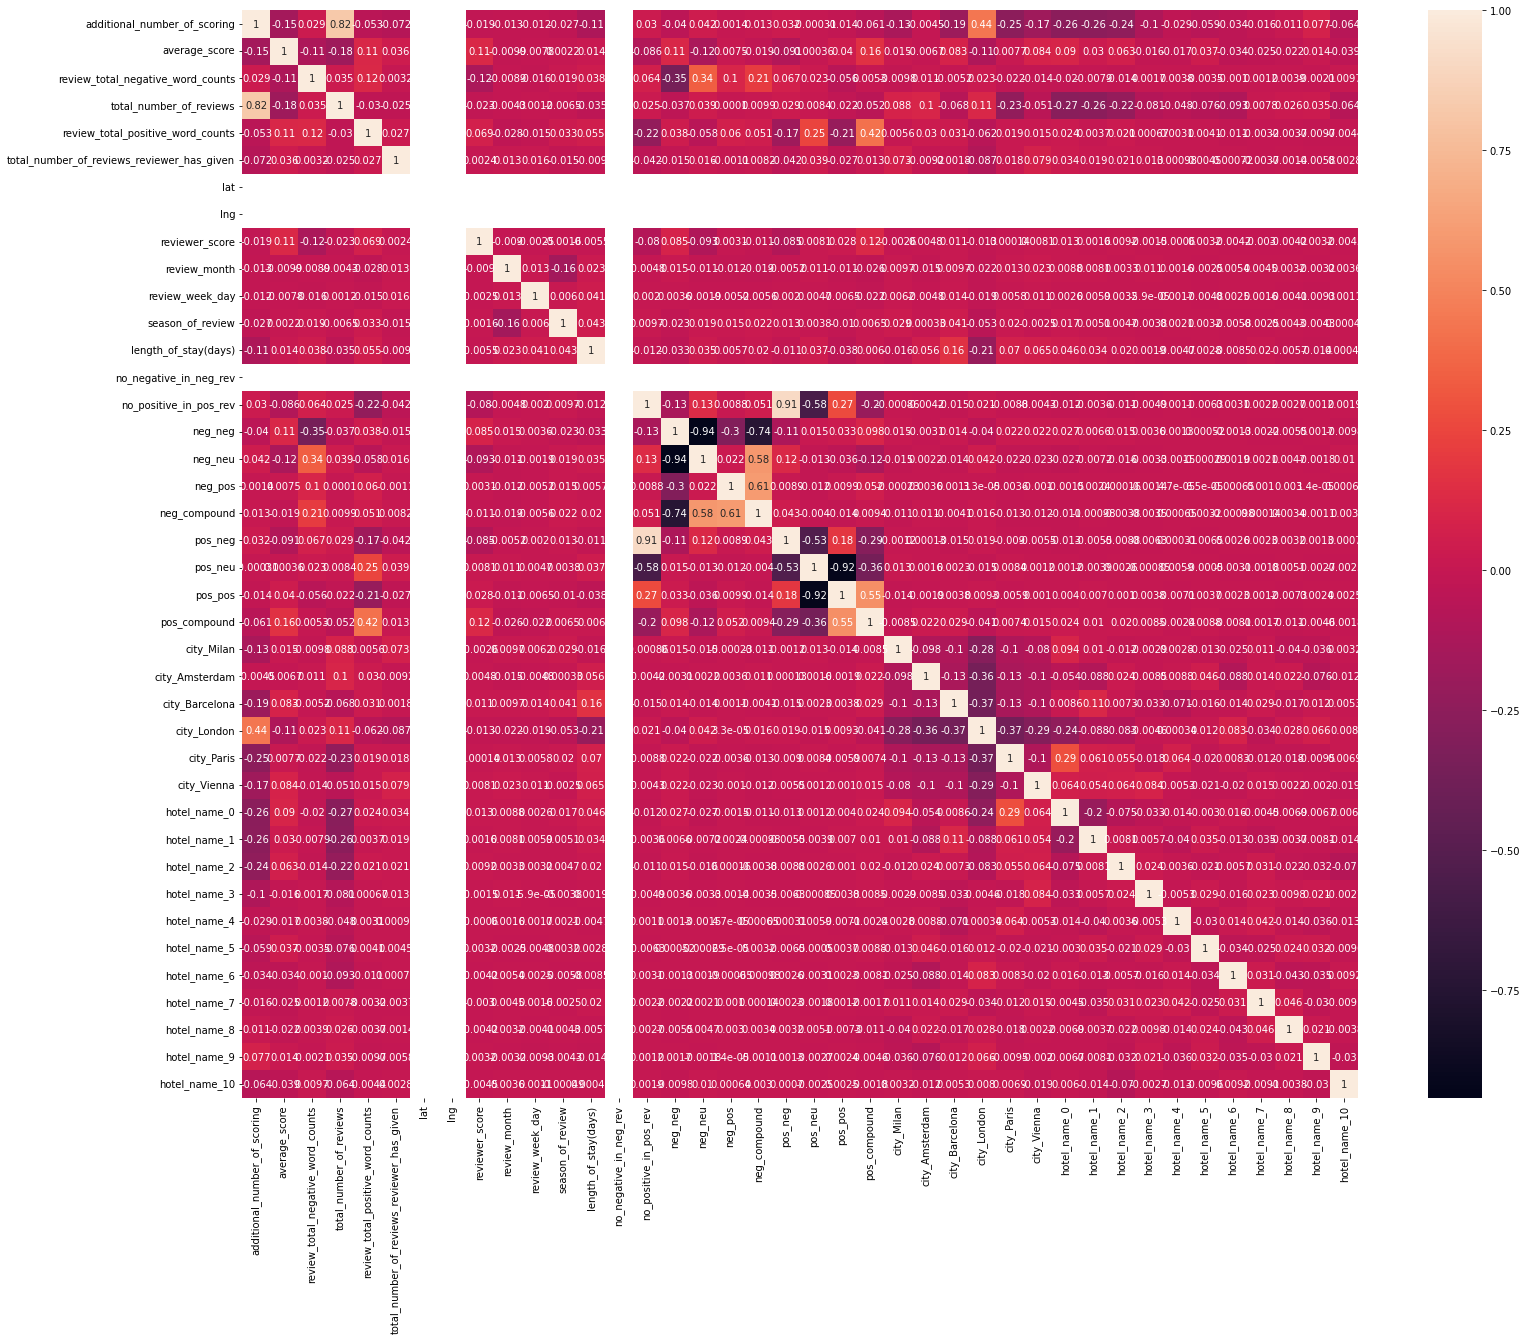

In [64]:
plt.rcParams['figure.figsize'] = (25,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Высокая корреляция наблюдается у очевидных зависимостей, например негативный окрас в позитивном отзыве с признаком ,нет позитива в позитивном отзыве'.

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 48 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [67]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  int64  
 7   lng                                         515738 non-null  int64  
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

__Итак посредством веделения наиболее значимой инофрмации из категориальных признаков, у нас получилось 48 признаков, удалили признаки с типом object, осталось 40 принаков. По ходу работы, я не очень то учитывала признаки местоположения отеля. Во-первых, врядли координаты влияют на оценку, опять таки, из характеристик отеля, на оценку скорее всего влияет соотношения реальности и ожидания, во-вторых, изучив работы студентов, понятно, что никак не повлияло на модель работы с указанными признаками.__

__Имеем датасет на 40 признаков, в основном работа проведена с тэгами и отзывами__

## Создание и обучение модели

In [82]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [83]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [84]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 40), (386803, 40), (386803, 39), (309442, 39), (77361, 39))

In [72]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [85]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [86]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [87]:

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [90]:
# Функция для рассчёта MAPE:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [91]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

print('MAPE:', mape(y_test, y_pred)) 
#print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)) 

MAE: 0.885005795617454
MAPE: 12.610560922261746


<AxesSubplot:>

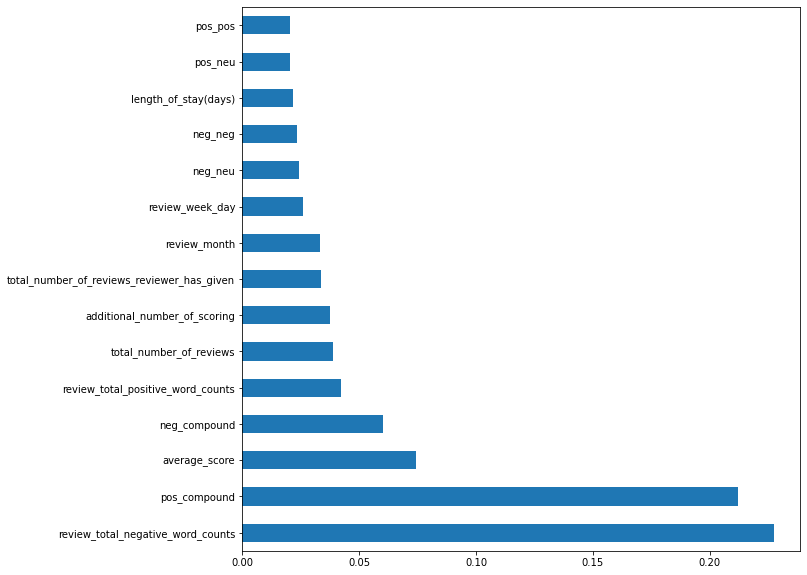

In [92]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [93]:
feat_importances.nlargest(15).index

Index(['review_total_negative_word_counts', 'pos_compound', 'average_score',
       'neg_compound', 'review_total_positive_word_counts',
       'total_number_of_reviews', 'additional_number_of_scoring',
       'total_number_of_reviews_reviewer_has_given', 'review_month',
       'review_week_day', 'neg_neu', 'neg_neg', 'length_of_stay(days)',
       'pos_neu', 'pos_pos'],
      dtype='object')

In [94]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,review_month,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
116841,256,9.1,21,949,7,2,0,0,0.0,6,...,0,1,1,0,0,1,1,0,0,0
12726,90,8.4,0,728,14,1,0,0,0.0,1,...,0,1,1,1,1,1,1,1,1,0
82639,589,7.0,18,4231,5,1,0,0,0.0,5,...,0,1,0,0,1,1,1,1,0,0
124010,602,8.5,59,2494,24,1,0,0,0.0,8,...,0,0,1,1,1,1,1,1,0,0
13875,234,8.0,32,1295,16,1,0,0,0.0,1,...,0,0,0,1,0,1,0,1,1,1
72719,710,7.9,27,6511,35,9,0,0,0.0,5,...,0,0,0,1,1,1,0,0,0,0
90315,1058,7.7,91,4380,0,1,0,0,0.0,6,...,0,1,0,1,1,0,1,1,1,0
28940,99,8.7,207,1005,53,25,0,0,0.0,2,...,1,0,0,1,1,0,0,1,0,0
87832,44,9.0,4,283,0,7,0,0,0.0,6,...,0,0,1,0,0,1,0,0,0,0
29753,765,8.4,2,4686,2,11,0,0,0.0,6,...,0,0,0,1,1,0,0,0,0,1


In [95]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [96]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [97]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished


In [98]:
predict_submission

array([8.518, 7.31 , 8.712, ..., 8.499, 9.555, 6.743])

In [99]:
list(sample_submission)

['reviewer_score', 'id']

## __Подготовка сабмишена__

In [100]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.518,488440
1,7.310,274649
2,8.712,374688
3,9.718,404352
4,9.618,451596
5,8.792,302161
6,7.706,317079
7,7.478,13963
8,8.337,159785
9,7.428,195089


__ВЫВОД:__

Была представлена информация по отзывам об 1492 отелях с сайта буккинга. Изначально, изучив текст отзывов и наполение датасета, была сформирована стратегия обработать категориальные признаки по тэгам и самому тексту отзывов. Можно было выделить еще множество признаков, по национальности ревьюера, по координатом, расположению от центра и так далее. Однако, упор был взят на тот факт, что оценка отеля не зависит от его местоположения (бронируя отель в Лондоне - вы попадаете в Лондон, бронируя отель на окраине Лондона - вы не ожидаете попасть в центр). Конечно, может быть, что, например, в Милане больше отелей с хорошей оценкой, чем в Барселоне, но будет ли оценка конкретному отелю с большей вероятностью выше, если он находится в Милане. Итак, проанализировав датасет, проведя разведовательный анализ данных, был получен результат, который Вы можете оценить в данной работе.